## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [24]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df.sort_index(inplace = True)

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df = df.resample('1H').sum()

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

##### Пустых значений нет

In [6]:
print(df.index.is_monotonic)

True


##### Фрейм упорядочен

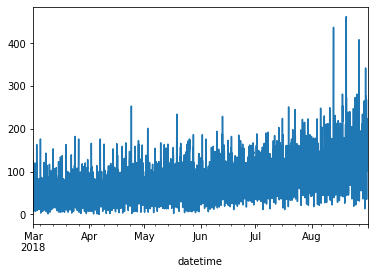

In [7]:
df['num_orders'].plot();

##### Добавим скользящее среднее

In [8]:
df['rolling_mean'] = df['num_orders'].shift().rolling(10).mean()

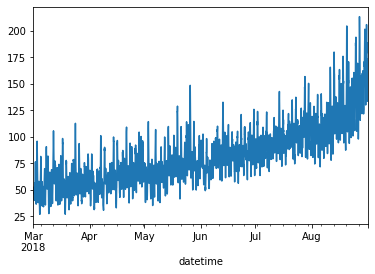

In [9]:
df['rolling_mean'].plot();

##### Скользящее среднее в общем и целом постоянно растет

##### Создадим нужные признаки 

In [10]:
#df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

##### Создадим цикл по добавлению отстающих значений

In [11]:
j = 6
for i in range(1, j + 1):
    df['lag_{}'.format(i)] = df['num_orders'].shift(i)

##### Разделим данные на выборки  приступим к обучению моделей

In [13]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis = 1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis = 1)
test_target = test['num_orders']

In [14]:
print(train.shape)
print(test.shape)

(3964, 10)
(442, 10)


In [15]:
display(train.tail(3))
display(test.head(3))

,num_orders,rolling_mean,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,
2018-08-13 11:00:00,144,159.3,13,11,156.0,137.0,91.0,39.0,66.0,83.0
2018-08-13 12:00:00,92,146.4,13,12,144.0,156.0,137.0,91.0,39.0,66.0
2018-08-13 13:00:00,119,111.9,13,13,92.0,144.0,156.0,137.0,91.0,39.0


,num_orders,rolling_mean,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,
2018-08-13 14:00:00,102,107.0,13,14,119.0,92.0,144.0,156.0,137.0,91.0
2018-08-13 15:00:00,175,102.9,13,15,102.0,119.0,92.0,144.0,156.0,137.0
2018-08-13 16:00:00,144,112.1,13,16,175.0,102.0,119.0,92.0,144.0,156.0


##### По времени все в порядке, тестовые данные идут сразу за обучающими

In [22]:
model = LinearRegression()
model.fit(train_features.values, train_target.values)
predictions = model.predict(test_features)
print('RMSE Линейной Регрессии:', mean_squared_error(test_target.values, predictions) ** 0.5)

RMSE Линейной Регрессии: 53.57423049836165


In [17]:
model.coef_, train_features.columns

(array([ 0.40736868,  0.06557879,  0.5166104 ,  0.44635055,  0.07402025,
        -0.0663585 , -0.05330331, -0.01217253, -0.05294415]),
 Index(['rolling_mean', 'day', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
        'lag_5', 'lag_6'],
       dtype='object'))

##### MAE около нуля

In [23]:
model1 = RandomForestRegressor()
model2 = RandomForestRegressor(max_depth = 20)
model3 = RandomForestRegressor(n_estimators = 150, max_depth = 20)

model1.fit(train_features, train_target)
model2.fit(train_features, train_target)
model3.fit(train_features, train_target)

predictions1 = model1.predict(test_features)
predictions2 = model2.predict(test_features)
predictions3 = model3.predict(test_features)

print('RMSE model1:', mean_squared_error(test_target, predictions1) ** 0.5)
print('RMSE model2:', mean_squared_error(test_target, predictions2) ** 0.5)
print('RMSE model3:', mean_squared_error(test_target, predictions3) ** 0.5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE model1: 51.47063104070618
RMSE model2: 47.357101809206206
RMSE model3: 47.33820790544792


In [25]:
parametrs = {
    'n_estimators' : range(100, 201, 50),
    'max_depth' : range(20, 31, 5),
}

In [26]:
model = RandomForestRegressor()
grd = GridSearchCV(model, parametrs, cv = 5)
grd.fit(train_features, train_target)
grd.best_params_

{'max_depth': 25, 'n_estimators': 100}

In [29]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 25)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
print('RMSE итоговой модели:', mean_squared_error(test_target, predictions) ** 0.5)

RMSE итоговой модели: 47.69170612307298


##### Из выбранных вариантов случайного леса, лучшие результаты показала модель с числом деревьев - 100, и максимальной глубиной - 20, хотя из раза в раз они в целом все показывают плюс-минус одинаковый результат, и не всегда наилучший именно второй

##### Наилучшая модель - линейная регрессия, с RMSE около нуля